# Regularized Logistic Regression



This notebook is an implemention of Regularized Logistic Regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure
it is functioning correctly.
Lets suppose we have the
test results for some microchips on two different tests. From these two tests,
we would like to determine whether the microchips should be accepted or
rejected. To help us make the decision, we have a dataset of test results
on past microchips, from which we can build a logistic regression model.

In [2]:
# Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt

from mpl_toolkits import mplot3d
from IPython.core.debugger import set_trace

%matplotlib inline

In [3]:
# Load the dataset as a dataframe 'df'
df = pd.read_table('data2.txt', delimiter=',', names=('Test_1', 'Test_2', 'Accepted?'))

In [4]:
# Print first few rows of the dataframe
df.head()

,Test_1,Test_2,Accepted?
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [5]:
# Check the columns of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
Test_1       118 non-null float64
Test_2       118 non-null float64
Accepted?    118 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.8 KB


In [6]:
# Display Summary Statistics
df.describe()

,Test_1,Test_2,Accepted?
count,118.000000,118.000000,118.000000
mean,0.054779,0.183102,0.491525
std,0.496654,0.519743,0.502060
min,-0.830070,-0.769740,0.000000
25%,-0.372120,-0.254385,0.000000
50%,-0.006336,0.213455,0.000000
75%,0.478970,0.646562,1.000000
max,1.070900,1.108900,1.000000


## Visualizing the data

Lets create a scatterplot with the test scores to visualize the data.

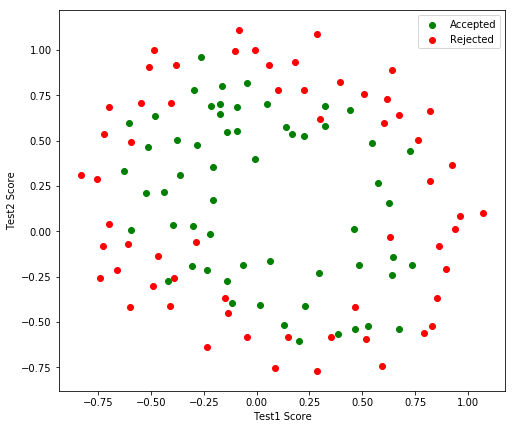

In [7]:
rejected = df[df['Accepted?']==0]
accepted = df[df['Accepted?']==1]

fig, ax = plt.subplots(figsize=(8,7))  
ax.scatter(accepted['Test_1'], accepted['Test_2'], c='g', marker='o', label='Accepted')  
ax.scatter(rejected['Test_1'], rejected['Test_2'], c='r', marker='o', label='Rejected')  

ax.legend(loc='upper right')

ax.set_xlabel('Test1 Score')
ax.set_ylabel('Test2 Score')
plt.show()

The above plot shows that our dataset cannot be separated into positive and
negative examples by a straight-line through the plot. Therefore, a straight-forward application of logistic regression will not perform well on this dataset
since logistic regression will only be able to find a linear decision boundary.

One way to deal with this using a linear technique like logistic regression is to construct features that are derived from polynomials of the original features. We can try creating a bunch of polynomial features to feed into the classifier.

## Feature Mapping

With the following code, we will map the features into
all polynomial terms of X1 and X2 up to the sixth power.

As a result of this mapping, our vector of two features (the scores on
two QA tests) has been transformed into a 28-dimensional vector. A logistic
regression classifier trained on this higher-dimension feature vector will have
a more complex decision boundary and will appear nonlinear when drawn in
our 2-dimensional plot.

While the feature mapping allows us to build a more expressive classifier,
it is also more susceptible to overfitting. In the next part, we
will implement regularized logistic regression to fit the data and also see how regularization can help combat the overfitting problem.

In [8]:
df.insert(3, 'X0', 1)   # Insert a column of 1's at the end

degree = 7
X1 = df['Test_1']  
X2 = df['Test_2']

for i in range(1, degree):  
    for j in range(0, i):
        df['F' + str(i) + str(j)] = np.power(X1, i-j) * np.power(X2, j)

# First 2 columns are not needed for the analysis so they can be removed from the dataframe
df.drop('Test_1', axis=1, inplace=True)  
df.drop('Test_2', axis=1, inplace=True)

# Print first 5 rows of the updated dataframe
df.head()         

,Accepted?,X0,F10,F20,F21,F30,F31,F32,F40,F41,...,F51,F52,F53,F54,F60,F61,F62,F63,F64,F65
0,1,1,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,...,0.000005,0.000066,0.000900,0.012278,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589
1,1,1,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,...,0.000051,-0.000374,0.002764,-0.020412,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981
2,1,1,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,...,0.001444,-0.004677,0.015151,-0.049077,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973
3,1,1,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,...,0.009931,-0.013299,0.017810,-0.023851,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978
4,1,1,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,...,0.032312,-0.029315,0.026596,-0.024128,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235


The dataframe 'df' has been updated with the new columns F10 to F65 as shown above. Here, column names refer to the powers of X1 and X2 used to create those columns. For example, F32 refers to $X_1^3$ * $X_2^2$, where $X_1$ and $X_2$ are Test_1 and Test_2 respectively.

## Cost function and Gradient

Now we will implement code to compute the cost function and gradient for
regularized logistic regression.

Regularization is a term in the cost function that causes the algorithm to prefer "simpler" models (in this case, models will smaller coefficients). The theory is that this helps to minimize overfitting and improve the model's ability to generalize.

The regularized cost function in logistic regression is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m [-y^{(i)}log(h_\theta(x^{(i)})) - (1-y^{(i)})log(1 - h_\theta(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note that we should not regularize the parameter $\theta_0$. The gradient
of the cost function is a vector where the j'th element is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}\sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})x_j^{(i)} \;,\;\;\;\;\; for\; j=0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \Bigg(\frac{1}{m}\sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}\Bigg) + \frac{\lambda}{m} \theta_j \;,\;\;\;\;\;for\;j>0 $$

In [9]:
# Define the sigmoid function
def sigmoid(z):
    return (1 / (1 + np.exp(-z)))

In [10]:
# Define the Regularized Cost function
def costFunctionReg(theta, X, y, lambda_reg):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    regularized = (lambda_reg / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    
    J = np.sum(first - second) / (len(X)) + regularized
    return J

In [11]:
# Define function to calculate gradient
def gradientReg(theta, X, y, lambda_reg):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)

    error = sigmoid(X * theta.T) - y

    for i in range(parameters):
        term = np.multiply(error, X[:,i])

        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((lambda_reg / len(X)) * theta[:,i])

    return grad

Lets calculate Cost and Gradient for initial $\theta$ values

In [12]:
# Set X and y
cols = df.shape[1]  
X2 = df.iloc[:,1:cols]  
y2 = df.iloc[:,0:1]

# Convert to numpy arrays and initalize the parameter array theta
X2 = np.array(X2.values)  
y2 = np.array(y2.values)  
theta2 = np.zeros(X2.shape[1])

learningRate = 0.01

cost_0 = costFunctionReg(theta2, X2, y2, learningRate)
gradient_0 = gradientReg(theta2, X2, y2, learningRate)
print('Cost when theta is an array of zeros = {0}'.format(cost_0))
print('Gradient when theta is an array of zeros = {0}'.format(gradient_0))

Cost when theta is an array of zeros = 0.6931471805599454
Gradient when theta is an array of zeros = [ 0.00847458  0.01878809  0.05034464  0.01150133  0.01835599  0.00732393
  0.00819244  0.03934862  0.00223924  0.01286005  0.00309594  0.01997075
  0.00432983  0.00338644  0.00583822  0.00447629  0.03103124  0.0010974
  0.00631571  0.0004085   0.00726504  0.00137646]


## Learning parameters using fmin_tnc

By using the function 'gradientReg', we don't actually perform gradient descent. We just compute a single gradient step. In the following steps, we use SciPy's optimization API to optimize the parameters, given functions to compute the cost and the gradients.

In [13]:
result = opt.fmin_tnc(func=costFunctionReg, x0=theta2, fprime=gradientReg, args=(X2, y2, learningRate))  
J_min = costFunctionReg(result[0], X2, y2, learningRate)
print('Error calculated using optimal theta is = {0}'.format(J_min))

Error calculated using optimal theta is = 0.6930233952230453


In [14]:
def predict(theta, X):
    h = sigmoid(X * theta.T)
    predictions = (h>=0.5)
    return predictions

In [15]:
theta_final = np.matrix(result[0])  
predictions = predict(theta_final, X2)  
correct_predictions = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y2)]  
accuracy = (sum(map(int, correct_predictions)) % len(correct_predictions))  
print('Accuracy = {0}%'.format(accuracy))

Accuracy = 88%
